In [1]:
import os
import re
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(1234)

from ml4cvd.arguments import parse_args, TMAPS, _get_tmap
from ml4cvd.TensorMap import TensorMap, Interpretation
from ml4cvd.tensor_generators import test_train_valid_tensor_generators, big_batch_from_minibatch_generator

TENSORS = '/mnt/disks/ecg-rest-38k-tensors/2020-03-14/'

In [2]:
sys.argv = ['mode', 
            '--tensors', TENSORS, 
            '--input_tensors', 'wiki_text_index', 'wiki_next_index',
            '--output_tensors', 'wiki_next_next_index',
            '--text_file', '/home/sam/enwiki-2020-07-03-subset.txt',
            '--text_window', '12',
            '--dense_layers', '64', '32',
            '--training_steps', '128',
            '--validation_steps', '36',
            '--patience', '9',
            '--batch_size', '32',
            '--epochs', '18',
            '--id', 'transformer_test',
           ]
args = parse_args()

VOCAB_SIZE = len(args.tensor_maps_in[0].channel_map)
BURN_IN = args.tensor_maps_in[1].shape[0]
TOKENS_TO_EMIT = args.tensor_maps_out[0].shape[0]

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)

2020-07-08 08:56:54,393 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/transformer_test/log_2020-07-08_08-56_0.log.
2020-07-08 08:57:48,494 - tensor_map_maker:241 - INFO - Total characters: 4960
2020-07-08 08:57:48,504 - tensor_map_maker:244 - INFO - char2index:

 {'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, '*': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26, ':': 27, ';': 28, '<': 29, '=': 30, '>': 31, '?': 32, '@': 33, 'A': 34, 'B': 35, 'C': 36, 'D': 37, 'E': 38, 'F': 39, 'G': 40, 'H': 41, 'I': 42, 'J': 43, 'K': 44, 'L': 45, 'M': 46, 'N': 47, 'O': 48, 'P': 49, 'Q': 50, 'R': 51, 'S': 52, 'T': 53, 'U': 54, 'V': 55, 'W': 56, 'X': 57, 'Y': 58, 'Z': 59, '[': 60, '\\': 61, ']': 62, '^': 63, '_': 64, '`': 65, 'a': 66, 'b': 67, 'c': 68, 'd': 69, 'e': 70, 'f': 71, 'g': 72, 'h': 73, 'i': 74, 'j': 75, 'k':

2020-07-08 08:57:52,444 - arguments:418 - INFO - Command Line was: 
./scripts/tf.sh mode --tensors /mnt/disks/ecg-rest-38k-tensors/2020-03-14/ --input_tensors wiki_text_index wiki_next_index --output_tensors wiki_next_next_index --text_file /home/sam/enwiki-2020-07-03-subset.txt --text_window 12 --dense_layers 64 32 --training_steps 128 --validation_steps 36 --patience 9 --batch_size 32 --epochs 18 --id transformer_test

2020-07-08 08:57:52,446 - arguments:419 - INFO - Total TensorMaps: 586 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=2.0, anneal_rate=0.0, anneal_shift=0.0, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=32, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, bottleneck_type=<BottleneckType.FlattenRestructure: 1>, cache_size=875000000.0, categorical_field_ids=[], continuous_field_ids=[], continuous_file=N

In [3]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(
            query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # concatenation of heads
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

In [5]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [6]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [7]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - \
        tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [8]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [9]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) /
                            tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [10]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [11]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer", input_name="inputs"):
    inputs = tf.keras.Input(shape=(None, d_model), name=input_name)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

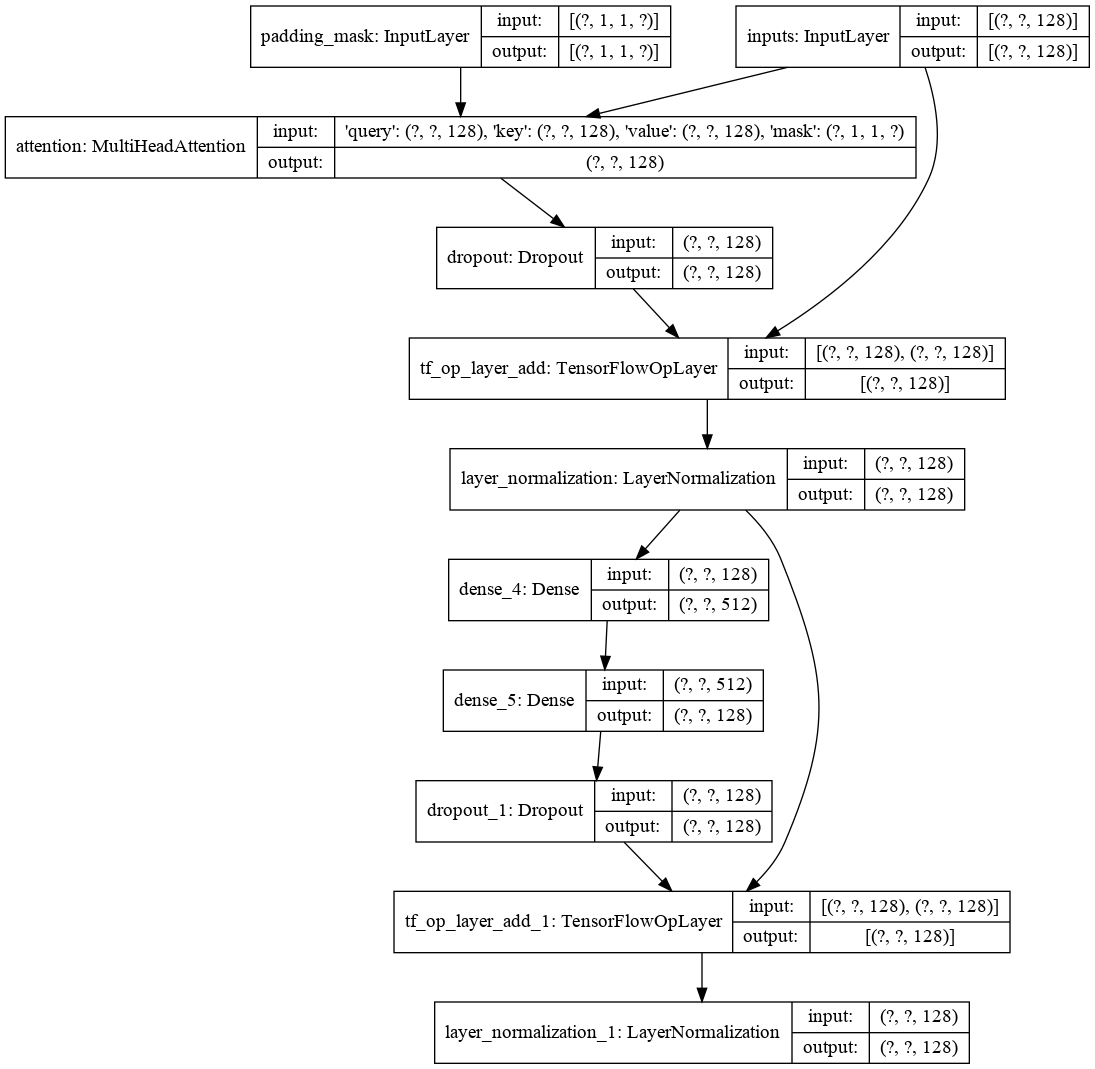

In [12]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

In [13]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder",
            input_name="inputs"):
    inputs = tf.keras.Input(shape=(None,), name=input_name)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
            input_name=input_name,
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [14]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

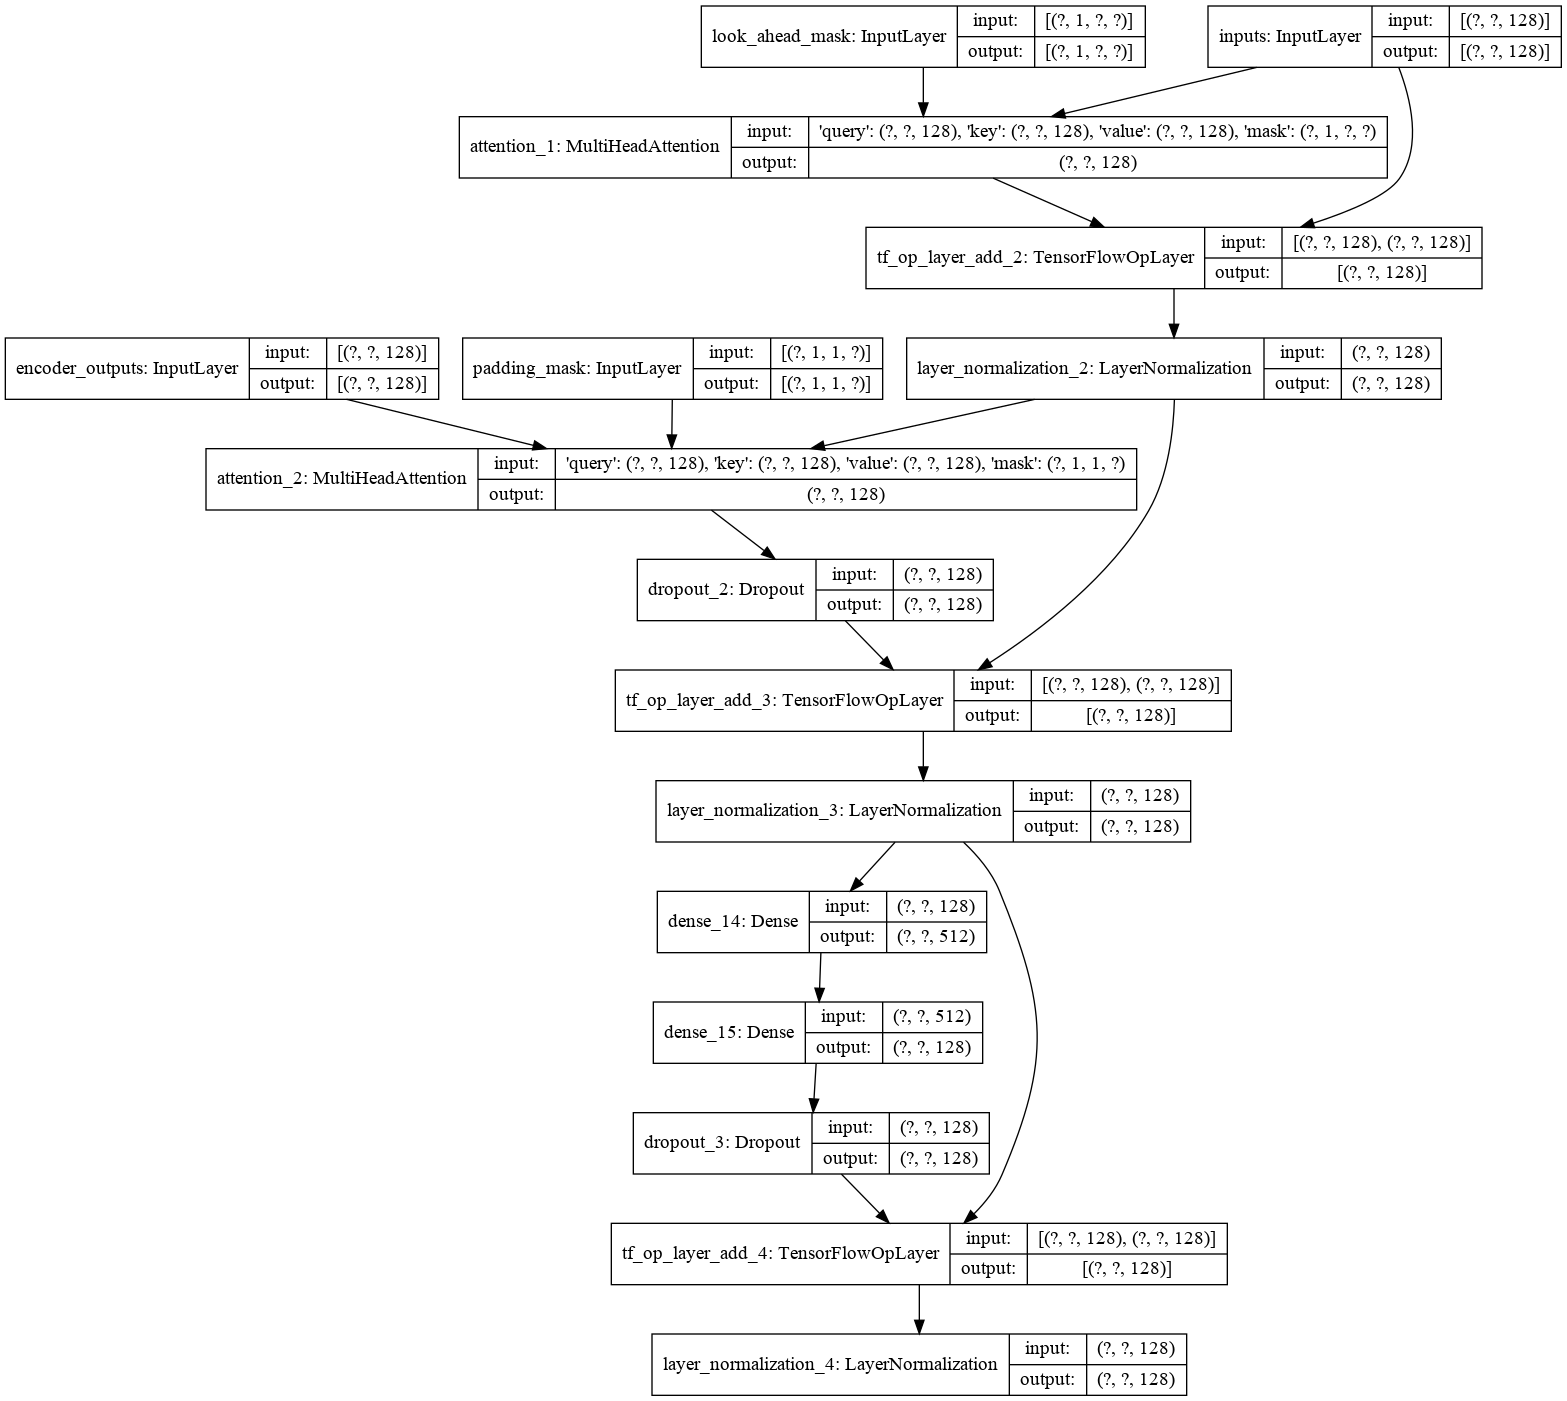

In [15]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

In [16]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder',
            input_name='inputs'):
    inputs = tf.keras.Input(shape=(None,), name=input_name)
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

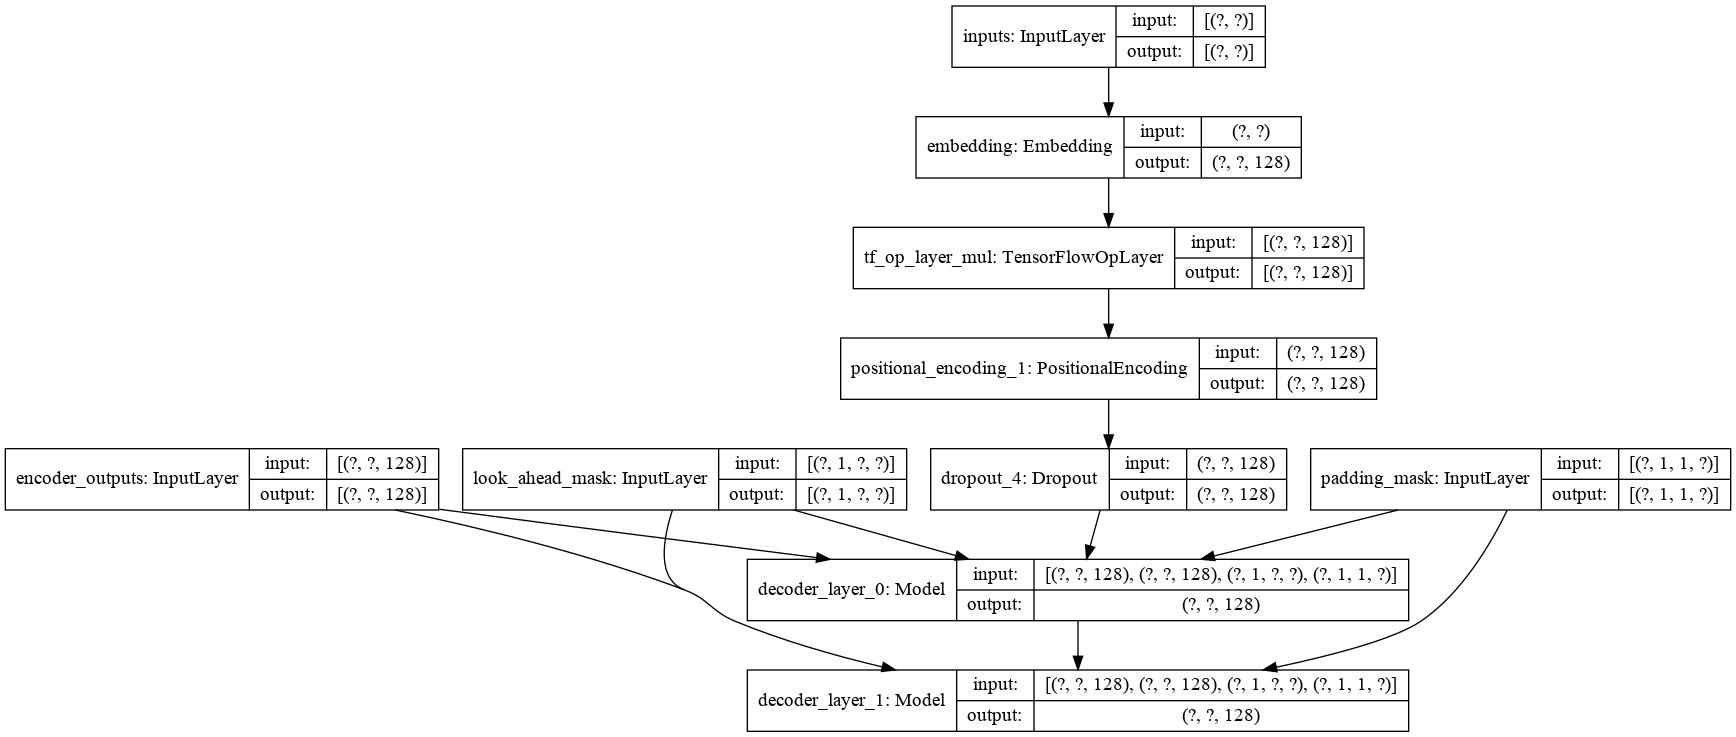

In [17]:
sample_decoder = decoder(
    vocab_size=VOCAB_SIZE,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

In [18]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer",
                input_name="inputs",
                decoder_input_name="dec_inputs",
                output_name="outputs"):
    inputs = tf.keras.Input(shape=(None,), name=input_name)
    dec_inputs = tf.keras.Input(shape=(None,), name=decoder_input_name)

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        input_name=input_name,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        input_name=input_name,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(
        units=vocab_size, name=output_name)(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [19]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    input_name=args.tensor_maps_in[0].input_name(),
    decoder_input_name=args.tensor_maps_in[1].input_name(),
    output_name=args.tensor_maps_out[0].output_name())

In [20]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, TOKENS_TO_EMIT))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [21]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [22]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

Text(0.5, 15.0, 'Train Step')

In [23]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, TOKENS_TO_EMIT)
    y_true = tf.reshape(y_true, shape=(-1, TOKENS_TO_EMIT))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [32]:
model.fit(generate_train, steps_per_epoch=args.training_steps, epochs=6*args.epochs, verbose=1,
          validation_steps=args.validation_steps, validation_data=generate_valid)

Train for 128 steps, validate for 36 steps
Epoch 1/108
128/128 [==============================] - 9s 71ms/step - loss: 0.3949 - accuracy: 0.8886 - val_loss: 0.3891 - val_accuracy: 0.8877
Epoch 2/108
128/128 [==============================] - 9s 70ms/step - loss: 0.3812 - accuracy: 0.8916 - val_loss: 0.3922 - val_accuracy: 0.8875
Epoch 3/108
 95/128 [=====================>........] - ETA: 2s - loss: 0.3857 - accuracy: 0.88932020-07-08 09:12:53,793 - tensor_generators:232 - INFO - 
!!!!>~~~~~~~~~~~~ train_worker completed true epoch 9 ~~~~~~~~~~~~<!!!!
Aggregated information string:
	Generator looped & shuffled over 25955 paths. Epoch: 9
	25955 tensors were presented.
	0 paths were skipped because they previously failed.
	No errors raised.
	
127/128 [============================>.] - ETA: 0s - loss: 0.3850 - accuracy: 0.88952020-07-08 09:12:56,720 - tensor_generators:232 - INFO - 
!!!!>~~~~~~~~~~~~ validation_worker completed true epoch 10 ~~~~~~~~~~~~<!!!!
Aggregated information string:

128/128 [==============================] - 9s 69ms/step - loss: 0.3620 - accuracy: 0.8982 - val_loss: 0.3584 - val_accuracy: 0.8968
Epoch 30/108
128/128 [==============================] - 9s 69ms/step - loss: 0.3667 - accuracy: 0.8969 - val_loss: 0.3652 - val_accuracy: 0.8945
Epoch 31/108
128/128 [==============================] - 9s 69ms/step - loss: 0.3778 - accuracy: 0.8924 - val_loss: 0.3982 - val_accuracy: 0.8916
Epoch 32/108
127/128 [============================>.] - ETA: 0s - loss: 0.3601 - accuracy: 0.89922020-07-08 09:17:13,245 - tensor_generators:232 - INFO - 
!!!!>~~~~~~~~~~~~ validation_worker completed true epoch 15 ~~~~~~~~~~~~<!!!!
Aggregated information string:
	Generator looped & shuffled over 7575 paths. Epoch: 15
	7575 tensors were presented.
	0 paths were skipped because they previously failed.
	No errors raised.
	
128/128 [==============================] - 9s 69ms/step - loss: 0.3596 - accuracy: 0.8994 - val_loss: 0.3715 - val_accuracy: 0.8947
Epoch 33/108
128/128 

 98/128 [=====================>........] - ETA: 1s - loss: 0.3581 - accuracy: 0.89932020-07-08 09:21:19,408 - tensor_generators:232 - INFO - 
!!!!>~~~~~~~~~~~~ train_worker completed true epoch 18 ~~~~~~~~~~~~<!!!!
Aggregated information string:
	Generator looped & shuffled over 25955 paths. Epoch: 18
	25955 tensors were presented.
	0 paths were skipped because they previously failed.
	No errors raised.
	
128/128 [==============================] - 9s 69ms/step - loss: 0.3539 - accuracy: 0.8998 - val_loss: 0.3575 - val_accuracy: 0.8978
Epoch 61/108
127/128 [============================>.] - ETA: 0s - loss: 0.3458 - accuracy: 0.90232020-07-08 09:21:30,764 - tensor_generators:232 - INFO - 
!!!!>~~~~~~~~~~~~ validation_worker completed true epoch 20 ~~~~~~~~~~~~<!!!!
Aggregated information string:
	Generator looped & shuffled over 7575 paths. Epoch: 20
	7575 tensors were presented.
	0 paths were skipped because they previously failed.
	No errors raised.
	
128/128 [=========================

128/128 [==============================] - 9s 69ms/step - loss: 0.3410 - accuracy: 0.9045 - val_loss: 0.3428 - val_accuracy: 0.9001
Epoch 89/108
128/128 [==============================] - 9s 68ms/step - loss: 0.3414 - accuracy: 0.9024 - val_loss: 0.3412 - val_accuracy: 0.9016
Epoch 90/108
127/128 [============================>.] - ETA: 0s - loss: 0.3362 - accuracy: 0.90282020-07-08 09:25:48,255 - tensor_generators:232 - INFO - 
!!!!>~~~~~~~~~~~~ validation_worker completed true epoch 25 ~~~~~~~~~~~~<!!!!
Aggregated information string:
	Generator looped & shuffled over 7575 paths. Epoch: 25
	7575 tensors were presented.
	0 paths were skipped because they previously failed.
	No errors raised.
	
128/128 [==============================] - 9s 69ms/step - loss: 0.3366 - accuracy: 0.9026 - val_loss: 0.3452 - val_accuracy: 0.9009
Epoch 91/108
128/128 [==============================] - 9s 68ms/step - loss: 0.3468 - accuracy: 0.9024 - val_loss: 0.3544 - val_accuracy: 0.9003
Epoch 92/108
 55/128 

In [33]:
test_data, test_labels, test_paths = big_batch_from_minibatch_generator(generate_test, 1)
index_2_token = {v: k for k, v in args.tensor_maps_in[0].channel_map.items()}
print(''.join([index_2_token[index] for index in test_data[args.tensor_maps_in[0].input_name()][2]]))
print(''.join([index_2_token[index] for index in test_data[args.tensor_maps_in[1].input_name()][2]]))
print(''.join([index_2_token[index] for index in test_labels[args.tensor_maps_out[0].output_name()][2]]))

2020-07-08 09:28:27,825 - tensor_generators:504 - INFO - Made a big batch of tensors with key:input_enwiki-2020-07-03-subset_language and shape:(32, 12).
2020-07-08 09:28:27,826 - tensor_generators:504 - INFO - Made a big batch of tensors with key:input_next_enwiki-2020-07-03-subset_language and shape:(32, 12).
2020-07-08 09:28:27,828 - tensor_generators:504 - INFO - Made a big batch of tensors with key:output_next_next_enwiki-2020-07-03-subset_language and shape:(32, 12).
 British Arm
British Army
ritish Army'


In [34]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def _sample_with_heat(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def sample_from_language_model(tensor_maps_in, language_input, model, test_data, max_samples=TOKENS_TO_EMIT):
    cur_test = {}
    burn_in = np.zeros((1,) + language_input.shape, dtype=np.float32)
    index_2_token = {v: k for k, v in language_input.channel_map.items()}
    for i in range(min(10, test_data[language_input.input_name()].shape[0])):  # iterate over the batch
        for k in test_data:
            cur_test[k] = np.expand_dims(test_data[k][i], axis=0)
        sentence = ''.join([index_2_token[index] for index in cur_test[language_input.input_name()][0]])
        sentence2 = ''.join([index_2_token[index] for index in cur_test[tensor_maps_in[1].input_name()][0]])
        full_sentence = f'{sentence}{sentence2[-1:]}'
        print(f'Start: {full_sentence}')
        for x in range(max_samples):
            prediction = model.predict(cur_test)
            next_token = index_2_token[_sample_with_heat(softmax(prediction[0, -1, :]), 0.5)]
            offset = 1
            full_sentence += next_token
            for k in test_data:
                if 'next' in k:
                    offset = 0
                for j in range(test_data[k].shape[1]):
                    cur_test[k][0, -(j+1)] = language_input.channel_map[full_sentence[-(1+j+offset)]]
            s = ''.join([index_2_token[index] for index in cur_test[language_input.input_name()][0]])
            s2 = ''.join([index_2_token[index] for index in cur_test[tensor_maps_in[1].input_name()][0]])
        print(f'Model: {full_sentence}             \n --- {i} --- \n')

In [35]:
sample_from_language_model(args.tensor_maps_in, args.tensor_maps_in[0], model, test_data, 64)

Start:  Jewish Law" 
Model:  Jewish Law" interies, the simples in 1960, the in the in defecters to exters             
 --- 0 --- 

Start: ween two pitc
Model: ween two pitcont and the charters const and a stears on the Eunguanal sedest              
 --- 1 --- 

Start:  British Army
Model:  British Army 1950 and a destating of the nimes to the procont of the a part              
 --- 2 --- 

Start: ddition to th
Model: ddition to the compring and 1950, an a elecomes the fecompers and counter com             
 --- 3 --- 

Start: es use chips 
Model: es use chips desters, dese of 156, in the trant the "impertant of the in the              
 --- 4 --- 

Start:  often credit
Model:  often credition state compain and in the restred and the the compulations. H             
 --- 5 --- 

Start: II talks star
Model: II talks stard to firsters of the post bread the stroulars by the Altersist a             
 --- 6 --- 

Start:  training (PE
Model:  training (PECaus, Stated and the Arthad the sta